In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
from tqdm import tqdm
import gc
from copy import deepcopy

import torch
import numpy as np
from torch import nn
import math
from models import *   
from v109 import *
from environment.gym_drone import DroneEnv, get_simple_direction
from core import generate_default_model_name

CPU times: user 2.26 s, sys: 21.3 ms, total: 2.28 s
Wall time: 1.22 s


HeteroData(
  agent={
    x=[1, 3],
    pos=[1, 12]
  },
  goal={
    x=[1, 3],
    pos=[1, 9]
  },
  obstacle={
    x=[11, 3],
    pos=[11, 2]
  },
  (agent, a_near_a, agent)={
    edge_index=[2, 0],
    edge_attr=[0, 24]
  },
  (goal, toward, agent)={
    edge_index=[2, 1],
    edge_attr=[1, 24]
  },
  (obstacle, o_near_a, agent)={
    edge_index=[2, 5],
    edge_attr=[5, 24]
  }
)

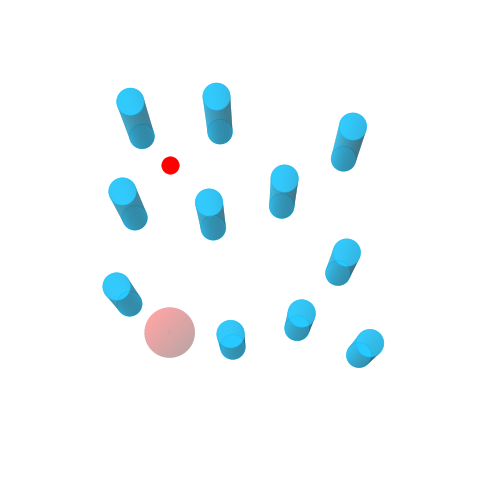

In [2]:
%%time 
env = create_env(num_agents=1)
env._render();
env._get_obs(**OBS_CONFIG)

2
2
CPU times: user 2min 17s, sys: 328 ms, total: 2min 18s
Wall time: 49.2 s


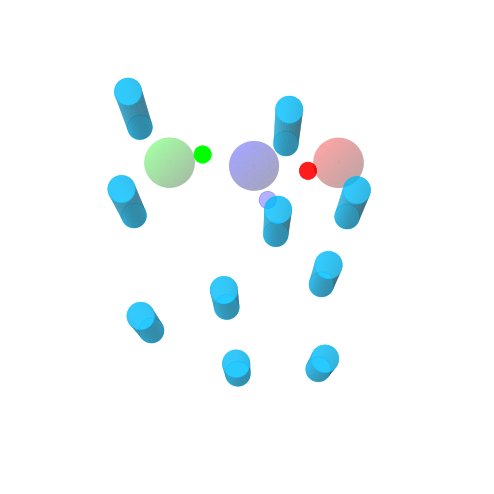

In [6]:
%%time

i = 0
idx = 2

np.random.seed(idx)
random.seed(idx)
env = create_env()

collide = np.zeros(3).astype(bool)
paths = [env.world.agents.copy()]
while True:
    if np.random.uniform() < 0.1:
        _, _, done, info = env.step(np.random.uniform(low=-1, high=1, size=(env.num_agents, env.action_dim)))
    else:
        _, _, done, info = env.step(get_simple_direction(env.world.agents, env.world.agent_goals))
    next_danger = info['next_danger'].data.cpu().numpy().astype(bool)
    paths.append(env.world.agents.copy())
    collide = collide | next_danger
    if done:
        break
if collide.any():
    print(idx)
    i += 1

print(i)
env.save_fig(agents=paths, goals=env.world.agent_goals, obstacles=env.world.obstacles, filename='shit.gif')

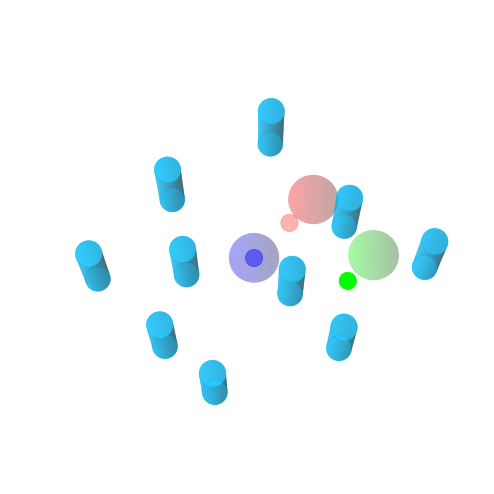

In [22]:
env.save_fig(agents=paths, goals=env.world.agent_goals, obstacles=env.world.obstacles, filename='shit.mp4')

# inference

In [3]:
bnn = create_network()
print(bnn.load_state_dict(torch.load('model_gnn/dbgnn_DroneEnv_v5_40.pt', map_location=device)))
bnn.eval();
# BMODEL_PATH
# BMODEL_PATH.replace('.pt', "_current.pt")
# BMODEL_PATH.replace('.pt', "_warmup.pt")
# BMODEL_PATH.replace('_'+version_name+'.pt', '_v22.pt')
# 'model_gnn/dbgnn_DubinsCarEnv13199_0.00.pt'
# 'model_gnn/dbgnn_DubinsCarEnv_v133999.pt'
# 'model_gnn/good_models/dbgnn_DubinsCarEnv_v114_66.pt'

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch_geometric/nn/conv/hetero_conv.py:53: UserWarning: There exist node types ({'obstacle'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


<All keys matched successfully>


In [ ]:
BMODEL_PATH.replace('.pt', "_current.pt")

In [2]:
%%time 
NUM_AGENTS, OBSTACLE_DENSITY, MAP_SIZE = 2048, 1.0, 4

for num_agents in list(2**np.arange(0, 12)):
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    
    valid_dataset = []
    for _ in range(100):
        env = create_env(num_agents=num_agents, size=max(int((num_agents*2)**0.5), 4), max_dist=6)  # num_agents=128, size=16, max_dist=4
        valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))
        
    import pickle as pkl

    with open(f'dataset/{project_name}_{num_agents}.pkl', 'wb') as f:
        pkl.dump(valid_dataset, f)

CPU times: user 56min 33s, sys: 29.4 s, total: 57min 3s
Wall time: 57min 8s


In [ ]:
torch.flatten(torch.randn(2, 3), start_dim=-2)

In [ ]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env = create_env()
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    # env.world.agents[1:,:]=-100
    # env.world.obstacles = [[1.499, 1.499]]
    collided, done, gifs = infer(env,bnn,verbose=False,spatial_prop=False,stop_at_collision=True)
    save_gif(gifs, 'gifs/0416/v115/'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

In [ ]:
%debug

# generalization

In [3]:
valid_dataset = []
for _ in range(1):
    # while True:
    # env = create_env(num_agents=2048, size=64)
    env = create_env(num_agents=2048, size=64)
    valid_dataset.append((env.world.obstacles.copy(), env.world.agent_goals.copy(), env.world.agents.copy()))

In [4]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env = create_env(num_agents=2048, size=64, density=0)
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    gif_file = 'gifs/0416/v115/2048_'+str(v_idx)+'.mp4'
    collided, done, gifs = infer(env,bnn,max_episode_length=1000,threshold=5e-2,verbose=False,spatial_prop=False,stop_at_collision=False,need_gif=None)
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

1it [20:07, 1207.33s/it]

0.05908203125 0.0 1001.0


In [7]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env = create_env(num_agents=2048, size=64, density=0)
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    gif_file = 'gifs/0416/v115/2048_'+str(v_idx)+'.mp4'
    collided, done, gifs = infer(env,bnn,max_episode_length=1000,threshold=5e-2,verbose=False,spatial_prop=False,stop_at_collision=False,need_gif=None)
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

1it [23:56, 1436.46s/it]

0.05908203125 0.0 1001.0


In [5]:
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env = create_env(num_agents=2048, size=64, density=0)
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    gif_file = 'gifs/0416/v115/2048_'+str(v_idx)+'.mp4'
    collided, done, gifs = infer(env,bnn,max_episode_length=1000,threshold=3e-2,verbose=False,spatial_prop=False,stop_at_collision=False,need_gif=None)
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

1it [20:16, 1216.28s/it]

0.12353515625 0.0 1001.0


In [11]:
import torch
from torch_sparse import SparseTensor
neighbor_sample = torch.ops.torch_sparse.neighbor_sample


def test_neighbor_sample():
    adj = SparseTensor.from_edge_index(torch.tensor([[0], [1]]))
    colptr, row, _ = adj.csc()

    # Sampling in a non-directed way should not sample in wrong direction:
    out = neighbor_sample(colptr, row, torch.tensor([0]), [1], False, False)
    print(out)

    # Sampling should work:
    out = neighbor_sample(colptr, row, torch.tensor([1]), [1], False, False)
    print(out)

    # Sampling with more hops:
    out = neighbor_sample(colptr, row, torch.tensor([1]), [1, 1], False, False)
    print(out)


def test_neighbor_sample_seed():
    colptr = torch.tensor([0, 3, 6, 9])
    row = torch.tensor([0, 1, 2, 0, 1, 2, 0, 1, 2])
    input_nodes = torch.tensor([0, 1, 2])

    torch.manual_seed(42)
    out1 = neighbor_sample(colptr, row, input_nodes, [1], True, True)
    print(out1)

    torch.manual_seed(42)
    out2 = neighbor_sample(colptr, row, input_nodes, [3, 1], False, True)
    print(out2)

In [12]:
test_neighbor_sample()

(tensor([0]), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
(tensor([1, 0]), tensor([1]), tensor([0]), tensor([0]))
(tensor([1, 0]), tensor([1]), tensor([0]), tensor([0]))


In [13]:
test_neighbor_sample_seed()

(tensor([0, 1, 2]), tensor([2, 2, 1]), tensor([0, 1, 2]), tensor([2, 5, 7]))
(tensor([0, 1, 2]), tensor([0, 1, 2, 0, 1, 2, 0, 1, 2]), tensor([0, 0, 0, 1, 1, 1, 2, 2, 2]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]))


In [ ]:
%debug

In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

plt.clf()
plt.close('all')

# Fixing random state for reproducibility
np.random.seed(19680801)


# Create new Figure and an Axes which fills it.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(0, 1), ax.set_xticks([])
ax.set_ylim(0, 1), ax.set_yticks([])

# Create rain data
n_drops = 50
rain_drops = np.zeros(n_drops, dtype=[('position', float, 2),
                                      ('size',     float, 1),
                                      ('growth',   float, 1),
                                      ('color',    float, 4)])

# Initialize the raindrops in random positions and with
# random growth rates.
rain_drops['position'] = np.random.uniform(0, 1, (n_drops, 2))
rain_drops['growth'] = np.random.uniform(50, 200, n_drops)

# Construct the scatter which we will update during animation
# as the raindrops develop.
scat = ax.scatter(rain_drops['position'][:, 0], rain_drops['position'][:, 1],
                  s=rain_drops['size'], lw=0.5, edgecolors=rain_drops['color'],
                  facecolors='none')


def update(frame_number):
    # Get an index which we can use to re-spawn the oldest raindrop.
    current_index = frame_number % n_drops

    # Make all colors more transparent as time progresses.
    rain_drops['color'][:, 3] -= 1.0/len(rain_drops)
    rain_drops['color'][:, 3] = np.clip(rain_drops['color'][:, 3], 0, 1)

    # Make all circles bigger.
    rain_drops['size'] += rain_drops['growth']

    # Pick a new position for oldest rain drop, resetting its size,
    # color and growth factor.
    rain_drops['position'][current_index] = np.random.uniform(0, 1, 2)
    rain_drops['size'][current_index] = 5
    rain_drops['color'][current_index] = (0, 0, 0, 1)
    rain_drops['growth'][current_index] = np.random.uniform(50, 200)

    # Update the scatter collection, with the new colors, sizes and positions.
    scat.set_edgecolors(rain_drops['color'])
    scat.set_sizes(rain_drops['size'])
    scat.set_offsets(rain_drops['position'])


# Construct the animation, using the update function as the animation director.
animation = FuncAnimation(fig, update, frames=200, interval=10)
f = r"animation.mp4" 
writermp4 = FFMpegWriter(fps=60) 
animation.save(f, writer=writermp4)

In [ ]:
@torch.no_grad()
def infer(env, bnn, threshold=None, max_episode_length=256, verbose=False, seed=0, stop_at_collision=False, prop=None, need_gif=True):
    if prop is None:
        prop = PROP
    
    if threshold is None:
        threshold=THRESHOLD
    if verbose:
        print('----------------------------------------')
        
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    if need_gif:
        gifs = [env._render()]
    else:
        gifs = [None]
    total_trans=0; n_danger=0; no_feasible=0; collided=np.zeros(env.num_agents).astype(bool)

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
        a_refines, bvalues = eval_action(bnn, o, a_all, max_iter=0, threshold=threshold)

        dists = env.potential_field(a_refines, K1=K1, K2=K2, ignore_agent=True)
        
        v = np.zeros(env.num_agents)
        a = np.zeros((env.num_agents, env.action_dim))
        evil_agents = set()
        for agent_id, a_refine, bvalue, dist in zip(np.arange(env.num_agents), a_refines, bvalues, dists):
            
            feasible_current = False
            if np.any(bvalue>threshold):
                feasible_current = True
            else:
                feasible_current = False
            
            if feasible_current:
                for a_idx in np.argsort(dist):
                    if bvalue[a_idx] > threshold:
                        a[agent_id] = a_refine[a_idx]
                        v[agent_id] = bvalue[a_idx]
                        break
                continue
            
            if prop:
                # find evil_agent
                local_o = o.clone()
                while True:
                    local_o.to('cpu')
                    edges = local_o['a_near_a'].edge_index
                    neighbor_edges = edges[1]==agent_id
                    if neighbor_edges.sum()==0:
                        break

                    first_edge = torch.where(neighbor_edges)[0][0]
                    mask = (torch.arange(edges.shape[1])==first_edge)
                    evil_agents.add(int(edges[0, first_edge]))
                    local_o['a_near_a'].edge_index = edges[:,~mask]
                    local_o['a_near_a'].edge_attr = local_o['a_near_a'].edge_attr[~mask,:]

                    local_a_refines, local_bvalues = eval_action(bnn, local_o, a_all, max_iter=0, threshold=threshold)          
                    # bvalues[agent_id] = bvalue = local_bvalues[agent_id]
                    # a_refine = local_a_refines[agent_id]

                    if np.any(local_bvalues>threshold):
                        break
            
            no_feasible += 1
            a[agent_id] = a_refine[np.argmax(bvalue)]
            v[agent_id] = bvalue[np.argmax(bvalue)]
                
        for evil_agent in evil_agents:
            a_refine, bvalue = a_refines[evil_agent], bvalues[evil_agent]
            a[evil_agent] = a_refine[np.argmax(bvalue)]
            v[evil_agent] = bvalue[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        
        prev_danger = info['prev_danger'].data.cpu().numpy().astype(bool)
        next_danger = info['next_danger'].data.cpu().numpy().astype(bool)
        if np.any(next_danger):
            collided = collided | next_danger
        if verbose:
            print(total_trans, np.where(v<=threshold), next_danger, evil_agents)
            
        total_trans += 1
        if need_gif:
            gifs.append(env._render())
        else:
            gifs.append(None)

        if np.any(next_danger) and stop_at_collision:
            break        
        
        if done or (total_trans >= max_episode_length):
            break

    return collided, done, gifs

In [ ]:
env = create_env()
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(valid_dataset[17])
_, _, gifs = infer(env, bnn, verbose=True,prop=True,stop_at_collision=True)
save_gif(gifs, 'gifs/0406/v59/shit2.gif')

In [ ]:
env.initColors()[6]

In [ ]:
edges = env._get_obs()['a_near_a'].edge_index
edges[0,edges[1]==5]

In [ ]:
valid_dataset[17][1]

In [ ]:
o = env._get_obs()
o = o.clone()

evil_agents = []
while True:
    o.to('cpu')
    agent_id = 0
    edges = o['a_near_a'].edge_index
    neighbor_edges = edges[1]==agent_id
    if neighbor_edges.sum()==0:
        break
    
    first_edge = torch.where(neighbor_edges)[0][0]
    mask = (torch.arange(edges.shape[1])==first_edge)
    evil_agents.append(int(edges[0, first_edge]))
    o['a_near_a'].edge_index = edges[:,~mask]
    o['a_near_a'].edge_attr = o['a_near_a'].edge_attr[~mask,:]

    a_all = np.random.uniform(-1, 1, size=(env.num_agents, n_candidates, env.action_dim))
    a_refines, bvalues = eval_action(bnn, o, a_all, max_iter=0, threshold=THRESHOLD)
    if (bvalues[0]>THRESHOLD).any():
        break

In [ ]:
neighbor_edges

In [ ]:
o['a_near_a'].edge_index 

In [ ]:
env.world.state

In [ ]:
x = torch.Tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]])
batch_x = torch.tensor([0, 0, 0, 0])
y = torch.Tensor([[-1, 0], [1, 0]])
batch_y = torch.tensor([0, 0])
assign_index = knn(x, y, 2, batch_x, batch_y)

In [ ]:
assign_index

In [ ]:
from potential_field import infer_p
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer_p(env)
    save_gif(gifs, 'gifs/dubins_no_obstacle/128_'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

In [ ]:
data = valid_dataset[18]
env = Env(num_agents=NUM_AGENTS, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
collided, done, gifs = infer(env, bnn, verbose=True)

In [ ]:
from potential_field import infer_p
collideds = []
dones = []
lengths = []
for v_idx, data in tqdm(enumerate(valid_dataset)):
    env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
    collided, done, gifs = infer_p(env, n_candidates=200, ignore_agent=False)
    save_gif(gifs, 'gifs/potential/dubins/128_'+str(v_idx)+'_'+str(np.any(collided))+'_'+str(done)+'.gif')
    collideds.append(collided)
    dones.append(done)
    lengths.append(len(gifs))
    
print(np.mean(collideds), np.mean(dones), np.mean(lengths))

In [ ]:
from potential_field import infer_p
data = valid_dataset[2]
env = Env(num_agents=1, mode='barrier', PROB=(0,OBSTACLE_DENSITY), SIZE=(MAP_SIZE,MAP_SIZE))
env.world.obstacles, env.world.agent_goals, env.world.agents = deepcopy(data)
collided, done, gifs = infer_p(env, verbose=True)
save_gif(gifs, 'why.gif')

In [ ]:
%debug